It seems the current [high scoring script][1] is written in R using H2O. So let us do one in python using XGBoost. 

Thanks to [this script][2] for feature engineering ideas. 

We shall start with importing the necessary modules


  [1]: https://www.kaggle.com/gospursgo/two-sigma-connect-rental-listing-inquiries/h2o-starter-pack/run/835757
  [2]: https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features

In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from XGBoostPackage import xgbClass
from CrossValidation import CVScore

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Now let us write a custom function to run the xgboost model.

In [2]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

Let us read the train and test files and store it.

In [3]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


We do not need any pre-processing for numerical features and so create a list with those features.

In [4]:
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

Now let us create some new features from the given features.

In [5]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words","created_year", "created_month", "created_day", "listing_id", "created_hour"])

We have 4 categorical features in our data

 - display_address
 - manager_id
 - building_id
 - listing_id

So let us label encode these features.

In [6]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

We have features column which is a list of string values. So we can first combine all the strings together to get a single string and then apply count vectorizer on top of it.

In [7]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


Now let us stack both the dense and sparse features into a single dataset and also get the target variable.

In [8]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

((49352, 217), (74659, 217))


Now let us do some cross validation to check the scores. 

Please run it in local to get the cv scores. I am commenting it out here for time.

In [9]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(train_X):
    #kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index], train_X[val_index]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break


[0]	train-mlogloss:1.04062	test-mlogloss:1.04178
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.988935	test-mlogloss:0.991194
[2]	train-mlogloss:0.945879	test-mlogloss:0.949042
[3]	train-mlogloss:0.909602	test-mlogloss:0.913573
[4]	train-mlogloss:0.877752	test-mlogloss:0.882525
[5]	train-mlogloss:0.847277	test-mlogloss:0.852886
[6]	train-mlogloss:0.821612	test-mlogloss:0.827856
[7]	train-mlogloss:0.797808	test-mlogloss:0.805061
[8]	train-mlogloss:0.778228	test-mlogloss:0.786171
[9]	train-mlogloss:0.762093	test-mlogloss:0.770583
[10]	train-mlogloss:0.745692	test-mlogloss:0.75503
[11]	train-mlogloss:0.731993	test-mlogloss:0.741936
[12]	train-mlogloss:0.719194	test-mlogloss:0.729753
[13]	train-mlogloss:0.707955	test-mlogloss:0.719276
[14]	train-mlogloss:0.696854	test-mlogloss:0.708794
[15]	train-mlogloss:0.68545	test-mlogloss:0.698564
[16]	train-mlogloss:0.677064	te

In [14]:
#np.mean(cv_scores)

<49352x217 sparse matrix of type '<type 'numpy.float64'>'
	with 1093045 stored elements in Compressed Sparse Row format>

In [10]:
model=xgbClass(eta=.1, colsample_bytree=.7, eva_metric="mlogloss", subsample=.7, max_depth=6, silent=1, seed=0, \
               num_class=3, objective='multi:softprob')
CVScore(model=model, my_score=log_loss, X_train=train_X, y_train=train_y, n_splits=5)

0.54990436153530886

Now let us build the final model and get the predictions on the test set.

In [11]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter2.csv", index=False)


Hope this helps the python users as a good starting point.

In [28]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(model.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)

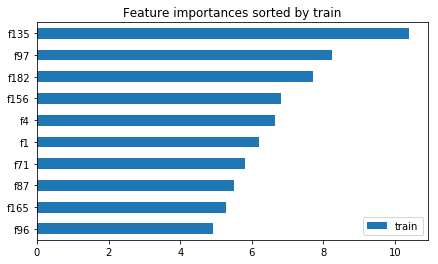

In [30]:
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))
